# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install -q scikit-learn==1.5.0
!pip install -q catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import (make_scorer, f1_score, classification_report, 
                             confusion_matrix, accuracy_score, precision_score, 
                            recall_score, roc_auc_score)
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier #
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import re
from typing import Dict, Iterable, List
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm_notebook
from tqdm.notebook import tqdm

nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ноут2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ноут2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ноут2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ноут2\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ноут2\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
pd.options.display.max_columns = None

In [5]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Пропусков нет, Удалим столбец Unnamed: 0

In [7]:
df = df.drop(['Unnamed: 0'],axis=1)

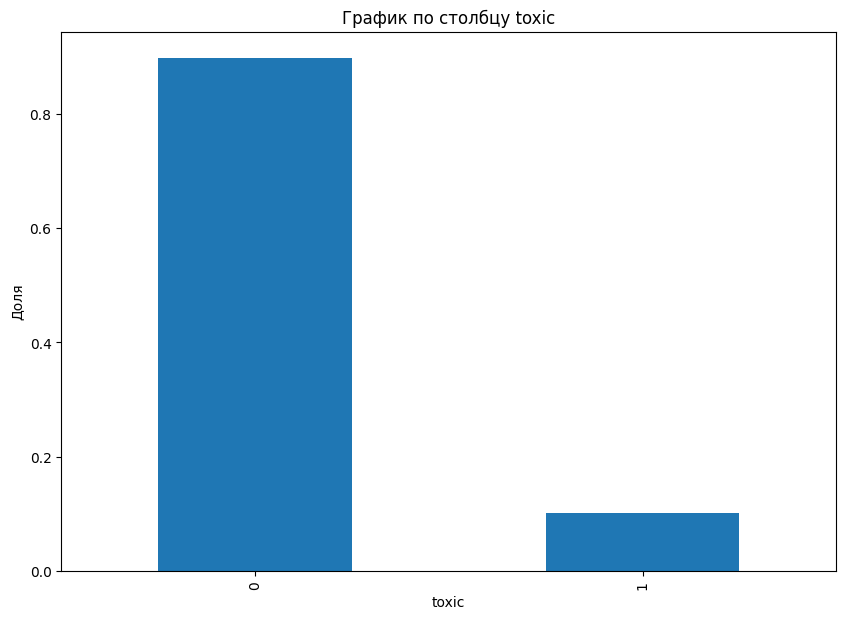

In [8]:
list_of_columns_bar = ['toxic']
for col in list_of_columns_bar:
    ax = df.value_counts(subset=col, ascending=False, normalize=True).plot.bar(figsize=(10, 7)) #, grid=True
    plt.title('График по столбцу '+col)
    plt.xlabel(col)
    plt.ylabel('Доля')
    plt.show()

Присутствует Дисбаланс классов

### Предобработка текста

In [9]:
text_dataset = df['text'].values

- Оставляем только символы Латиницы
- Лемматизируем с учетом части речи

In [10]:
def tokenize(text):
    return re.findall("[abcdefghijklmnopqrstuvwxyz]+", text.lower())

In [11]:
stopword_set = set(nltk.corpus.stopwords.words("english"))

In [12]:
def is_known_word(word):
    return bool(wordnet.synsets(word))

In [13]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

In [14]:
def lemmatize_with_pos(word):
    pos = get_wordnet_pos(pos_tag([word])[0][1])  
    return lemmatizer.lemmatize(word, pos=pos)

In [15]:
lemmatizer = WordNetLemmatizer()
lemmatizer_data = {}

def lemmatize(word):
    if is_known_word(word):
        if word not in lemmatizer_data:
            lemmatizer_data[word] = lemmatize_with_pos(word)
        return lemmatizer_data[word]
    return word

In [16]:
def prepare_text(texts):
    prepared_sentences = []
    for text in tqdm(texts):
        lemmatized_words = [lemmatize(word) for word in tokenize(text)]
        # Убираем стоп-слова
        filtered_words = [word for word in lemmatized_words if word not in stopword_set]
        prepared_sentences.append(filtered_words)  
    return prepared_sentences

In [17]:
text_dataset = prepare_text(text_dataset)

  0%|          | 0/159292 [00:00<?, ?it/s]

Проверяем что количество строк соответсует исходному

In [18]:
len(text_dataset)

159292

In [19]:
len(text_dataset) == len(df[['toxic']])

True

Оставляем очищенный текст и целевую переменную

In [20]:
df['lem_text'] = [' '.join(words) for words in text_dataset]

In [21]:
df = df.drop('text', axis=1)
df.head()

,toxic,lem_text
0,0,explanation edits make username hardcore metal...
1,0,aww match background colour seemingly stuck th...
2,0,hey man really try edit war guy constantly rem...
3,0,make real suggestion improvement wonder sectio...
4,0,sir hero chance remember page


Удалем дубликаты

In [22]:
df.duplicated().sum()

1923

In [23]:
df.drop_duplicates(inplace=True)

## Обучение

### Подготовка к обучению

In [24]:
X = df['lem_text']
y = df['toxic']

Делим на тренировочную и тестовую выборки со стратификацией по 'toxic'

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print (X_test.shape, y_test.shape, y_test.sum())
print (X_train.shape, y_train.shape, y_train.sum())

(31474,) (31474,) 3197
(125895,) (125895,) 12786


Пропорции по классу сохраняются

### Непосредственно обучение

Дерево и лес не справились и долго считались поэтому закомментированы

Выполняем TF-IDF преобразование в Pipeline, стоп слова удалять не будем - так выше точность.

In [26]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=2, stop_words=None)),
    ("selector", SelectKBest(score_func=f_classif)),
    ("classifier", LogisticRegression()) 
])

In [27]:
param_grid = [
    {
        "selector__k": range(35000, 265000, 5000), 
        "classifier": [LogisticRegression(random_state=42, class_weight="balanced")],
        "classifier__C": [10] 
    },
    {
        "selector__k": [700, 750, 800], 
        "classifier": [CatBoostClassifier(verbose=100, random_state=42)],
        "classifier__depth": [5],
        "classifier__iterations": [1000],
        "classifier__learning_rate": [0.2]
    }
]

In [28]:
grid = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(f1_score),
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [29]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9, min_df=2,
                                                        ngram_range=(1, 2))),
                                       ('selector', SelectKBest()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(class_weight='balanced',
                                                            random_state=42)],
                          'classifier__C': [10],
                          'selector__k': range(35000, 265000, 5000)},
                         {'classifier': [<catboost.core.CatBoostClassifier object at 0x000002268F68F9D0>],
                          'classifier__depth': [5],
                          'classifier__iterations': [1000],
                          'classifier__learning_rate': [0.2],
                          'selector__k': [700, 750, 800]}],
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

In [30]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2))),
                ('selector', SelectKBest(k=45000)),
                ('classifier',
                 LogisticRegression(C=10, class_weight='balanced',
                                    random_state=42))])


In [31]:
result = pd.DataFrame(grid.cv_results_)
result = result.sort_values('rank_test_score')
display(result.head(7))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_selector__k,param_classifier__depth,param_classifier__iterations,param_classifier__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,19.113974,0.673638,6.865472,0.114532,"LogisticRegression(class_weight='balanced', ra...",10.0,45000,NaN,NaN,NaN,{'classifier': LogisticRegression(class_weight...,0.771002,0.773583,0.774900,0.773162,0.001619,1
9,23.746925,0.340303,6.781451,0.045728,"LogisticRegression(class_weight='balanced', ra...",10.0,80000,NaN,NaN,NaN,{'classifier': LogisticRegression(class_weight...,0.770826,0.771641,0.776386,0.772951,0.002452,2
43,23.262488,0.624528,6.310975,0.055991,"LogisticRegression(class_weight='balanced', ra...",10.0,250000,NaN,NaN,NaN,{'classifier': LogisticRegression(class_weight...,0.773630,0.770814,0.771659,0.772035,0.001180,3
39,26.971935,0.673015,7.963954,0.435855,"LogisticRegression(class_weight='balanced', ra...",10.0,230000,NaN,NaN,NaN,{'classifier': LogisticRegression(class_weight...,0.769903,0.772784,0.772361,0.771683,0.001270,4
8,23.889204,0.815883,6.859516,0.130810,"LogisticRegression(class_weight='balanced', ra...",10.0,75000,NaN,NaN,NaN,{'classifier': LogisticRegression(class_weight...,0.768686,0.772223,0.773831,0.771580,0.002149,5
10,23.667912,0.603044,7.182197,0.515720,"LogisticRegression(class_weight='balanced', ra...",10.0,85000,NaN,NaN,NaN,{'classifier': LogisticRegression(class_weight...,0.769478,0.770421,0.773644,0.771181,0.001784,6
12,24.761025,0.592754,6.924394,0.159650,"LogisticRegression(class_weight='balanced', ra...",10.0,95000,NaN,NaN,NaN,{'classifier': LogisticRegression(class_weight...,0.768823,0.772368,0.772300,0.771164,0.001655,7


In [32]:
display('Метрика F1 для лучшей модели по кросс-валидации:', grid.best_score_)

'Метрика F1 для лучшей модели по кросс-валидации:'

0.7731616120221844

## Выводы

Параметры лучшей модели: 

In [33]:
result.iloc[0]['params']

{'classifier': LogisticRegression(class_weight='balanced', random_state=42),
 'classifier__C': 10,
 'selector__k': 45000}

Проверим её метрику на тестовой выборке

In [34]:
predict= grid.best_estimator_.predict(X_test)

In [35]:
f1_sc = f1_score(y_test, predict)
print(f'Значение метрики F1 для лучшей модели  на тестовых данных: {f1_sc}')

Значение метрики F1 для лучшей модели  на тестовых данных: 0.7680798004987531


Значение метрики F1 > 0.75 и соответсует необходимому

Рассмотрим другие метрики классификации

In [36]:
print("Классификационный отчёт:")
print(classification_report(y_test, predict, digits=4))

# Дополнительно:
print(f"Accuracy:  {accuracy_score(y_test, predict):.4f}")
print(f"Precision: {precision_score(y_test, predict):.4f}")
print(f"Recall:    {recall_score(y_test, predict):.4f}")
print(f"F1-score:  {f1_score(y_test, predict):.4f}")

# Матрица ошибок
print("________")
cm = confusion_matrix(y_test, predict)

TN, FP, FN, TP = cm.ravel()

print("Confusion Matrix (с пояснениями):\n")
print(f"               Predicted")
print(f"              0       1")
print(f"Actual  0   {TN:5}   {FP:5}    ← TN / FP")
print(f"        1   {FN:5}   {TP:5}    ← FN / TP\n")

print(f"🔹 True Negatives (TN): {TN}")
print(f"🔹 False Positives (FP): {FP}")
print(f"🔹 False Negatives (FN): {FN}")
print(f"🔹 True Positives (TP): {TP}")

Классификационный отчёт:
              precision    recall  f1-score   support

           0     0.9792    0.9646    0.9718     28277
           1     0.7232    0.8189    0.7681      3197

    accuracy                         0.9498     31474
   macro avg     0.8512    0.8917    0.8700     31474
weighted avg     0.9532    0.9498    0.9511     31474

Accuracy:  0.9498
Precision: 0.7232
Recall:    0.8189
F1-score:  0.7681
________
Confusion Matrix (с пояснениями):

               Predicted
              0       1
Actual  0   27275    1002    ← TN / FP
        1     579    2618    ← FN / TP

🔹 True Negatives (TN): 27275
🔹 False Positives (FP): 1002
🔹 False Negatives (FN): 579
🔹 True Positives (TP): 2618


Сохраняем лучшую модель из GridSearchCV

In [37]:
best_model = grid.best_estimator_

In [38]:
predictions_final_test = best_model.predict(X_test)

Финальная проверка что все работает

In [39]:
f1_final_test = f1_score(y_test, predictions_final_test)
print(f'Значение метрики F1 для лучшей модели  на тестовых данных: {f1_final_test}')

Значение метрики F1 для лучшей модели  на тестовых данных: 0.7680798004987531


### Вывод текстовый

Для определения "Токсичности" комментарие был представлен датасет из 159292 строк. 
- Пропуски отсутсвуют.
- Дисбаланс классов Токсичных -10% не Токсичных -90%

Был удален не информативный столбец Unnamed: 0.

Была выполнена подготовка текста включающая:
- Токинизацию
- Лемматизацию с учетом части речи
- Очистку от стоп слов

Для каждого текста получена соответсвующая строка очищенного текста.

- После удалены 1923 дубликата.
- Делим на тренировочную и тестовую выборки в соотношении 4/1 со стратификацией по 'toxic'- целевой переменной

TF-IDF преобразование выполняется на этапе pipeline для корректной кросс-валидации

- Стоп слова на этом этапе удалять не будем - так выше точность.
- Сначала преобразование на тренировочной выборке с кросс-валидацией
- При тестировании в модель передается столбец очищенного текста.


Изначально в ходе обучения рассматривались 4 модели:
- LogisticRegression()
- DecisionTreeClassifier()
- RandomForestClassifier()
- CatBoostClassifier()

Но две из них
- DecisionTreeClassifier()
- RandomForestClassifier()

Показали низкие результаты и в итоговый прогон не включались

Лидером стала - LogisticRegression(C=10, class_weight='balanced') с SelectKBest(k=45000)
- Метрика F1 на тренировочной выборке по результатам кросс-вализации - 0.7731616120221844
- Метрика F1 на тестовых данных: 0.7680798004987531

Значение метрики F1 > 0.75 и соответсует необходимому

- другие метрики  - Precision: 0.7232 и Recall: 0.8189

Также Рассмотрели Confusion Matrix 